# MFCC
----

Son coeficientes para la representación del habla basados en la percepción au-ditiva humana. Estos surgen de la necesidad, en el área del reconocimiento de au-dio automático, de extraer características de las componentes de una señal de audio que sean adecuadas para la identificación de contenido relevante, así como obviartodas aquellas que posean información poco valiosa como el ruido de fondo, emo-ciones, volumen, tono, etc. y que no aportan nada al proceso de reconocimiento, al contrario, lo empobrecen.Al tomar muestras es necesario pre-procesar las señales obtenidas. Aquí sedebe entender cómo se representa mejor la información en las señales a procesar,con el fin de extraer los datos más relevantes para alimentar la red neuronal.Para que el uso de la red neuronal funcione, es necesario asegurarse que elprocesamiento de la señal arroje la menor cantidad de características suficientescomo para que la red pueda identificar los sonidos y su implementación sea menos compleja. Por esta razón, se utiliza el análisis de los coeficientes cepstrales de Mel

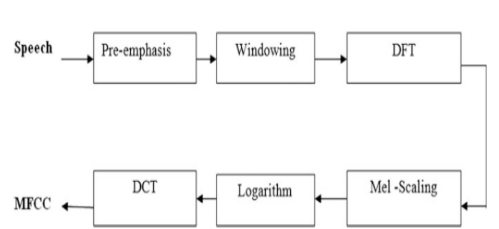

• Preénfasis

• La ventana

• La transformada discreta de Fourier (DFT)

• La escala mel

• El cálculo del logaritmo

• La transformada discreta del coseno (DCT).

## Implementacion propia

In [11]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.signal import get_window

In [2]:
sample_rate, amplitudes = wavfile.read("curita.wav")

In [4]:
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(amplitudes) / sample_rate))

Sample rate: 48000Hz
Audio duration: 13.973333333333333s


In [5]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

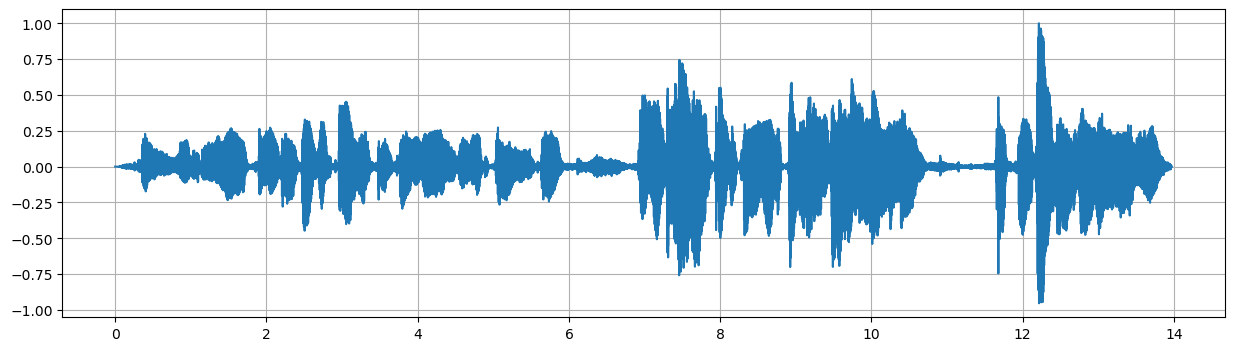

In [6]:
audio = normalize_audio(amplitudes)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

### Pre-enfasis
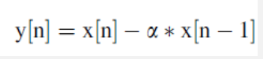

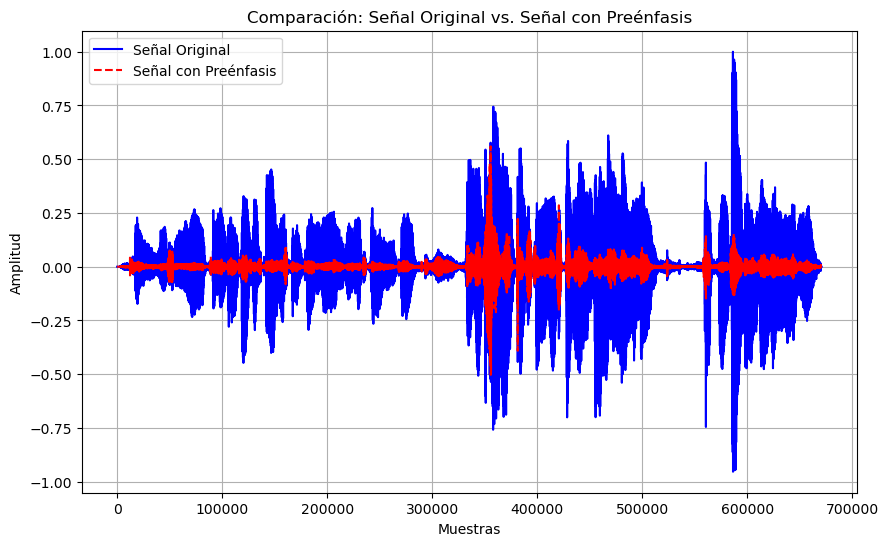

In [10]:
# Definir el coeficiente de preénfasis
alpha = 0.97

# Aplicar el preénfasis
y_preemphasized = np.zeros(len(audio))
y_preemphasized[0] = audio[0]  # No hay muestra anterior para la primera muestra

for n in range(1, len(audio)):
    y_preemphasized[n] = audio[n] - alpha * audio[n - 1]

# Comparar señales
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(audio, label='Señal Original', color='blue')
ax.plot(y_preemphasized, linestyle='--', label='Señal con Preénfasis', color='red')
ax.legend()
ax.set_title('Comparación: Señal Original vs. Señal con Preénfasis')
ax.set_xlabel('Muestras')
ax.set_ylabel('Amplitud')
plt.grid(True)
plt.show()

### Windowing

In [22]:
# Parámetros del ventaneo
frame_size = int(0.03 * sample_rate)  # Tamaño del frame (30 ms)
hop_size = int(0.01 * sample_rate)    # Tamaño del salto (10 ms)

def frame_audio(audio, frame_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(frame_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - frame_size) / frame_len) + 1
    frames = np.zeros((frame_num,frame_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+frame_size]
    
    return frames

In [23]:
hop_size = 15 #ms
frame_size = 2048

audio_framed = frame_audio(y_preemphasized, frame_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (932, 2048)


In [24]:
print("First frame:")
audio_framed[1]

First frame:


array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([ 4.10693970e-04,  5.21046644e-04,  5.21046644e-04, ...,
       -3.33712552e-05, -3.22335988e-05, -3.10959424e-05])

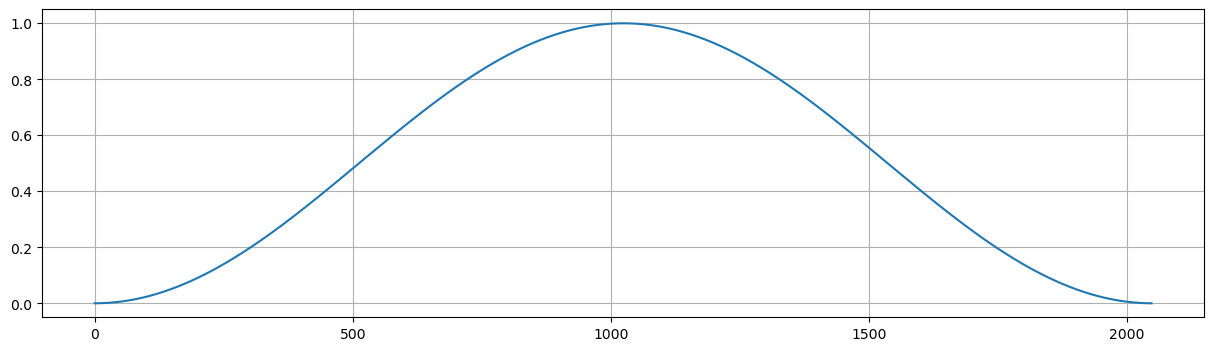

In [27]:
window = get_window("hann", frame_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

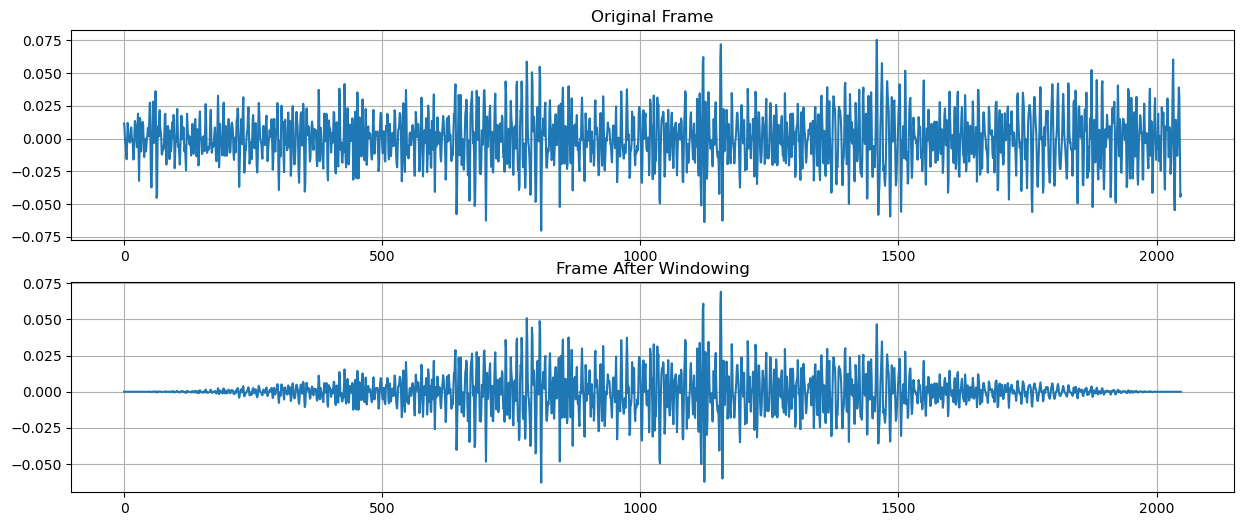

In [28]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

### FFT
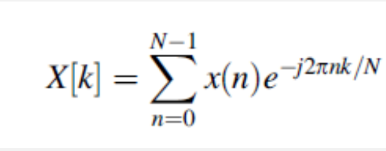

In [30]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + frame_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [31]:
audio_power = np.square(np.abs(audio_fft))
print('Energy: ', audio_power.shape)

Energy:  (932, 1025)


### Mel filter bank

In [32]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 24000.0


In [33]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [34]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [41]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, frame_size, sample_rate)
filter_points

MEL min: 0.0
MEL max: 4016.019179871836


array([   0,   11,   27,   49,   79,  121,  178,  258,  369,  521,  732,
       1024])

In [42]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

In [43]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

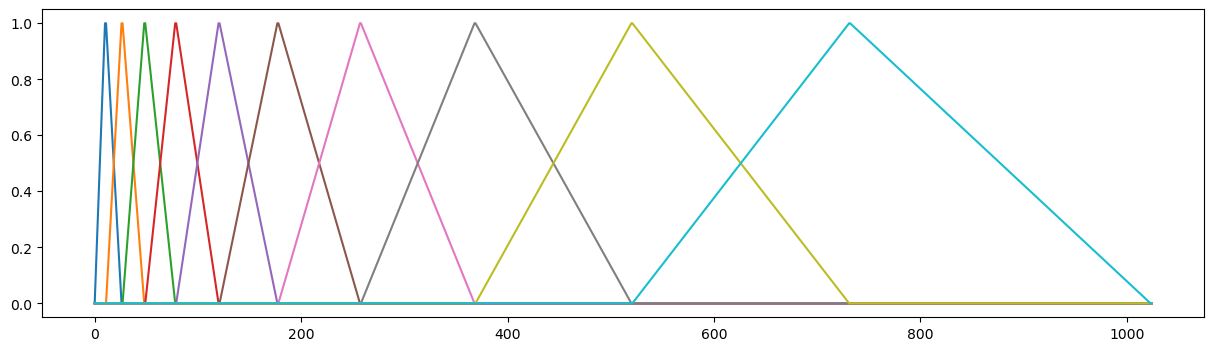

In [44]:
filters = get_filters(filter_points, frame_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [45]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

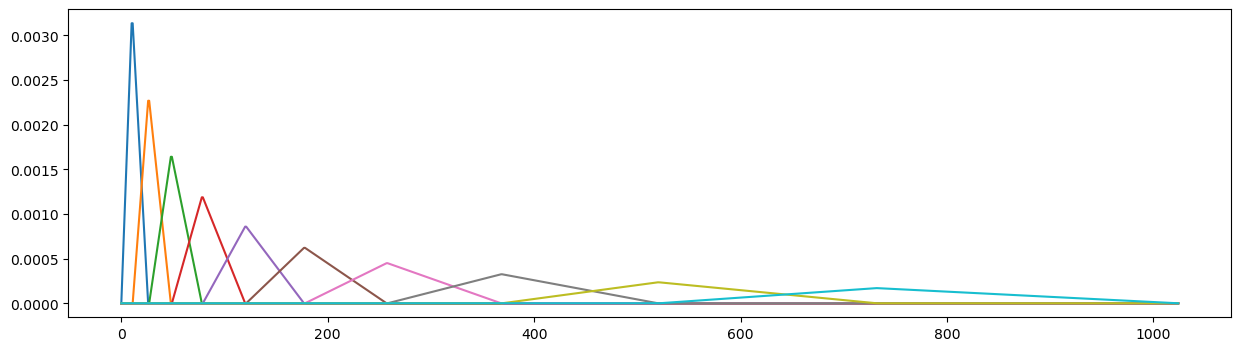

In [46]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [47]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

C:\Users\MrJel\AppData\Local\Temp\ipykernel_19208\2531907619.py:2: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10.0 * np.log10(audio_filtered)


(10, 932)

### DCT

In [48]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [49]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 932)

In [50]:
cepstral_coefficents[:, 0]

array([-inf,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  inf,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan])

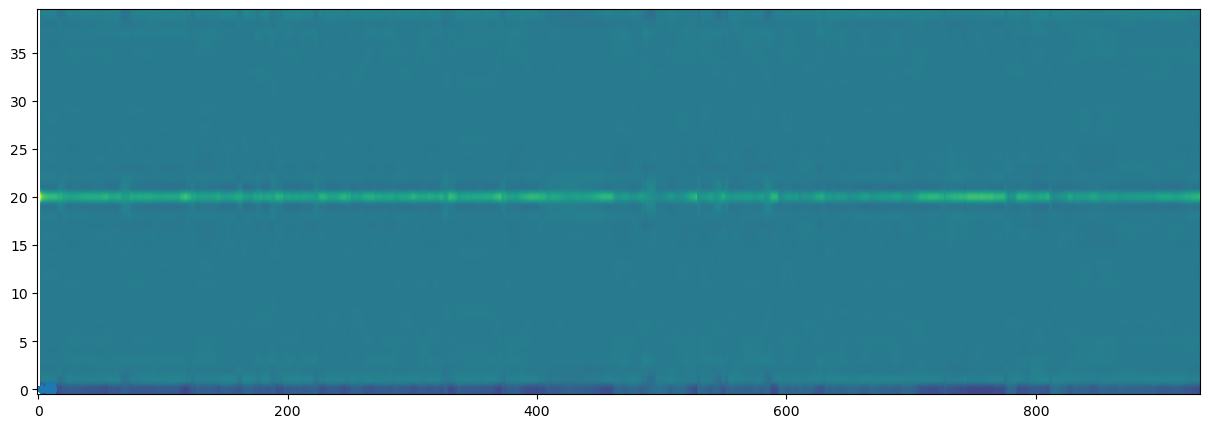

In [51]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

## Librosa

In [52]:
import librosa

In [55]:
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128,
                                   fmax=8000)

[Text(0.5, 1.0, 'MFCC')]

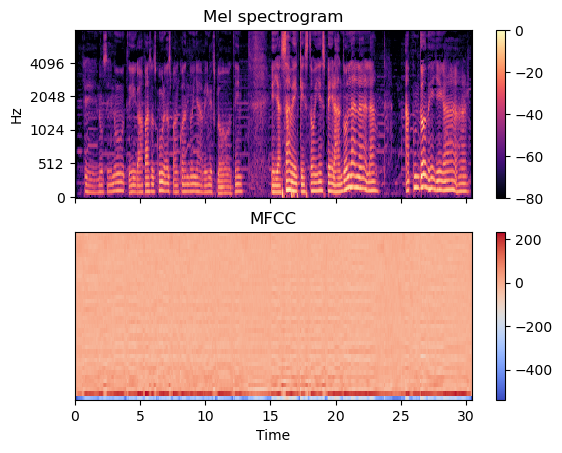

In [56]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')